In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# PRE-PROCESS

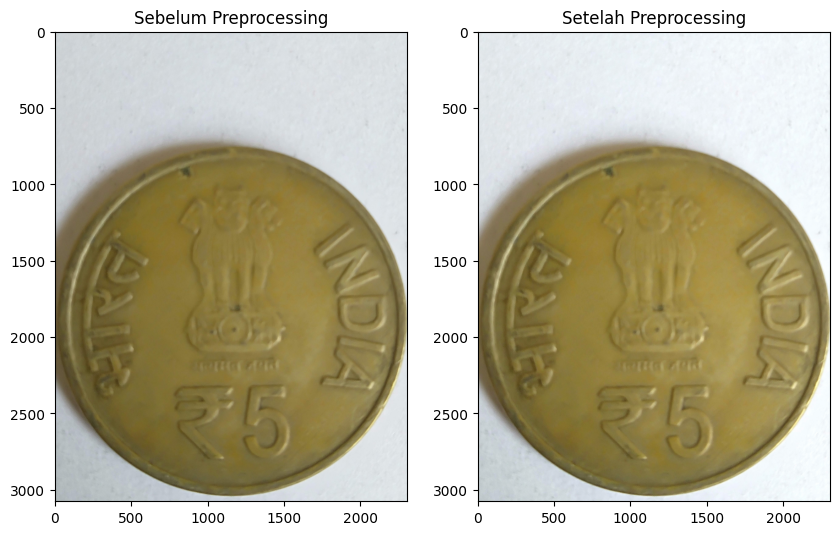

In [ ]:
import numpy as np  #Library ini digunakan untuk melakukan operasi numerik dan manipulasi array multidimensi.
import pandas as pd  # Library untuk manipulasi dan analisis data
import matplotlib.pyplot as plt # Library untuk visualisasi data
from sklearn.model_selection import train_test_split   # Library untuk membagi dataset
from sklearn.metrics import accuracy_score   # Library untuk mengukur akurasi
import os # Library untuk berinteraksi dengan sistem operasi
import cv2  #Library untuk pengolahan citra
from skimage import exposure   # Library untuk ekualisasi histogram dan penyesuaian kontras

# Mendefinisikan kelas dan label
classes = {
    'emas': 0,
    'perak': 1
}

# Mendefinisikan path dataset koin
dataset_path = '/content/drive/MyDrive/Final Project Pengolahan Citra Digital/Dataset/Training'

# Mendefinisikan faktor penajaman warna
color_enhancement_factor = 1.1

# Mendefinisikan fungsi untuk penajaman warna pada citra
def enhance_color(image, color_enhancement_factor):
    enhanced_image = cv2.convertScaleAbs(image, alpha=color_enhancement_factor, beta=0)
    return enhanced_image

# Mendefinisikan list untuk menyimpan citra hasil preprocessing
preprocessed_images = []

# Loop melalui setiap file citra dalam dataset
for class_name, class_label in classes.items():
    class_path = os.path.join(dataset_path, class_name)
    for image_file in os.listdir(class_path):
        if image_file.endswith('.jpg') or image_file.endswith('.png'):
            image_path = os.path.join(class_path, image_file)
            # Membaca citra menggunakan OpenCV
            image = cv2.imread(image_path)
            # Preprocessing dengan penajaman warna
            enhanced_image = enhance_color(image, color_enhancement_factor)
            # Menambahkan citra hasil preprocessing ke dalam list
            preprocessed_images.append((image, enhanced_image, class_label))

# Menampilkan contoh citra sebelum dan sesudah preprocessing
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(cv2.cvtColor(preprocessed_images[0][0], cv2.COLOR_BGR2RGB))
axes[0].set_title('Sebelum Preprocessing')
axes[1].imshow(cv2.cvtColor(preprocessed_images[0][1], cv2.COLOR_BGR2RGB))
axes[1].set_title('Setelah Preprocessing')
plt.show()


# SEGMENTASI

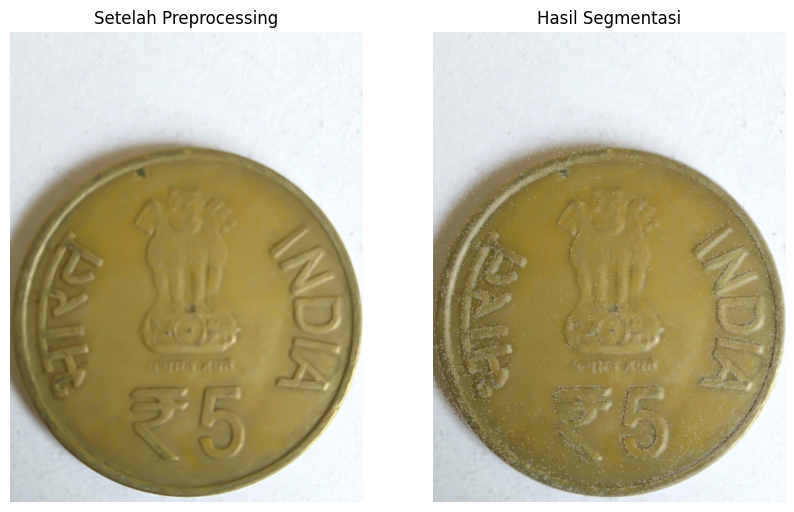

In [ ]:
# Fungsi untuk melakukan segmentasi dengan metode Canny Edge Detection dan menimpa garis tepi di atas gambar asli
def segment_canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Mengubah citra menjadi skala abu-abu
    edges = cv2.Canny(gray, 50, 100)  # Menggunakan metode Canny Edge Detection dengan threshold 50 dan 150
    segmented_image = np.copy(image)  # Membuat salinan gambar asli
    segmented_image[edges != 0] = (192, 192, 192)  # Mengganti warna garis tepi menjadi hijau
    return segmented_image

# Fungsi untuk melakukan segmentasi pada dataset koin training
def segment_dataset(images):
    segmented_images = []  # List untuk menyimpan gambar-gambar hasil segmentasi
    for image in images:  # Loop untuk setiap gambar dalam dataset
        segmented_image = segment_canny(image[1])  # Melakukan segmentasi pada gambar hasil preprocessing
        segmented_images.append((image[1], segmented_image, image[2]))  # Menambahkan citra hasil preprocessing, citra hasil segmentasi, dan label kelas ke list segmented_images
    return segmented_images

# Lakukan segmentasi pada dataset koin training
segmented_images = segment_dataset(preprocessed_images)

# Tampilkan contoh gambar hasil segmentasi
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(cv2.cvtColor(segmented_images[0][0], cv2.COLOR_BGR2RGB))
axes[0].set_title('Setelah Preprocessing')
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(segmented_images[0][1], cv2.COLOR_BGR2RGB))
axes[1].set_title('Hasil Segmentasi')
axes[1].axis('off')
plt.show()


# AUGMENTASI

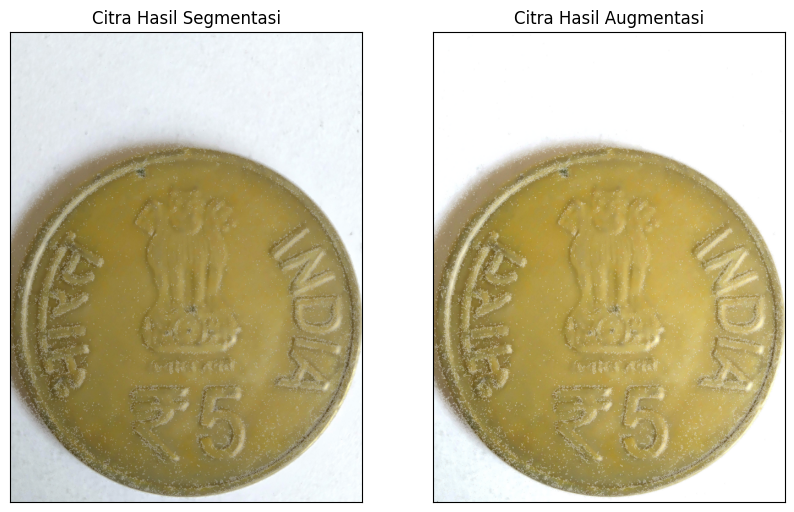

In [ ]:
# Mendefinisikan faktor kecerahan
brightness_factor = 1.2

# Mendefinisikan list untuk menyimpan citra hasil augmentasi
augmented_images = []

# Loop melalui setiap citra hasil segmentasi
for original_image, preprocessed_image, class_label in segmented_images:
    # Mengatur kecerahan citra hasil segmentasi
    brightened_segmented_image = cv2.convertScaleAbs(preprocessed_image, alpha=brightness_factor, beta=0)

    # Menambahkan citra hasil segmentasi dan citra augmentasi ke dalam list
    augmented_images.append((preprocessed_image, brightened_segmented_image, class_label))

# Menampilkan contoh citra hasil segmentasi dan augmentasi
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(cv2.cvtColor(augmented_images[0][0], cv2.COLOR_BGR2RGB))
axes[0].set_title('Citra Hasil Segmentasi')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Menghilangkan kontur pada citra hasil augmentasi menggunakan metode Canny
augmented_image_without_contour = augmented_images[0][1].copy()
gray_augmented_image = cv2.cvtColor(augmented_image_without_contour, cv2.COLOR_BGR2GRAY)

# Menggunakan metode Canny untuk mendapatkan tepi
edges = cv2.Canny(gray_augmented_image, 50, 150)

# Menemukan kontur pada citra hasil augmentasi
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Menggambar kontur pada citra hasil augmentasi dengan latar belakang hitam
cv2.drawContours(augmented_image_without_contour, contours, 0, (0, 0, 0), thickness=cv2.FILLED)

axes[1].imshow(cv2.cvtColor(augmented_image_without_contour, cv2.COLOR_BGR2RGB))
axes[1].set_title('Citra Hasil Augmentasi')
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.show()


#EKSTRASI FITUR

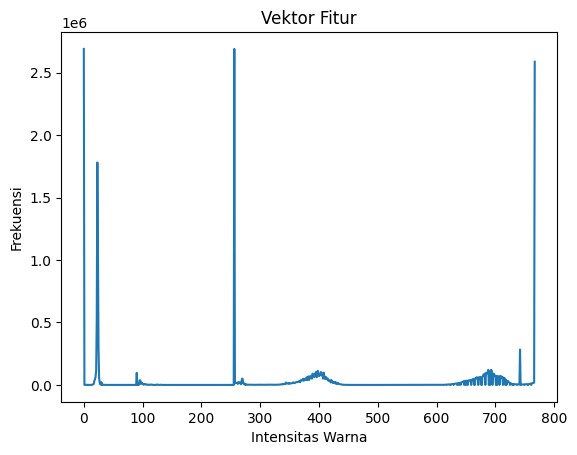

In [ ]:
# Fungsi untuk ekstraksi fitur menggunakan fitur warna (HSV)
def extract_color_features(image):
    # Konversi citra ke HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Menghitung histogram hue
    hist_hue = cv2.calcHist([hsv], [0], None, [256], [0, 256])
    hist_hue = hist_hue.flatten()

    # Menghitung histogram saturation
    hist_saturation = cv2.calcHist([hsv], [1], None, [256], [0, 256])
    hist_saturation = hist_saturation.flatten()

    # Menghitung histogram value
    hist_value = cv2.calcHist([hsv], [2], None, [256], [0, 256])
    hist_value = hist_value.flatten()

    # Menggabungkan histogram menjadi satu vektor fitur
    feature_vector = np.concatenate((hist_hue, hist_saturation, hist_value))

    return feature_vector

# Mendefinisikan list untuk menyimpan vektor fitur hasil ekstraksi
feature_vectors = []

# Loop melalui setiap citra hasil augmentasi
for original_image, augmented_image, class_label in augmented_images:
    # Ekstraksi fitur menggunakan fitur warna
    color_features = extract_color_features(augmented_image)

    # Menambahkan vektor fitur ke dalam list
    feature_vectors.append(color_features)

# Menampilkan contoh vektor fitur
num_examples = 1  # Jumlah contoh yang ingin ditampilkan

for i in range(num_examples):
    # Menampilkan vektor fitur
    plt.plot(feature_vectors[i])
    plt.title('Vektor Fitur')
    plt.xlabel('Intensitas Warna')
    plt.ylabel('Frekuensi')
    plt.show()


# ALGORITMA KLASIFIKASI SVM

Training Score: 0.9705882352941176
Testing Score: 1.0


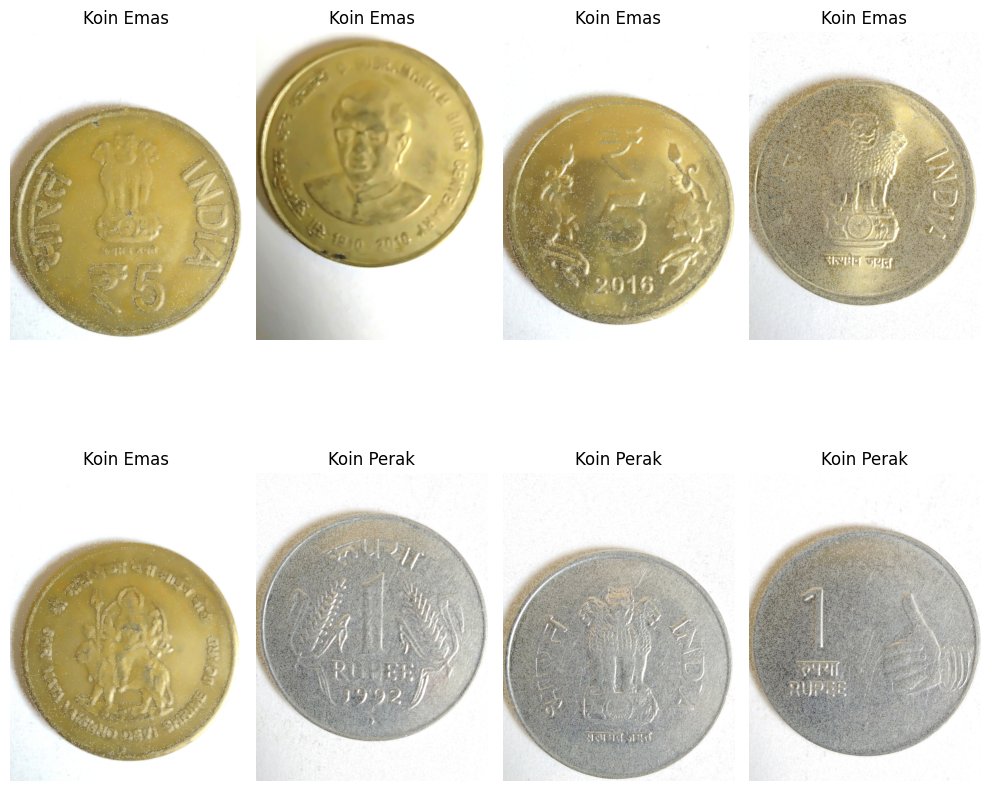

In [ ]:
# Mendefinisikan list untuk menyimpan vektor fitur hasil ekstraksi
feature_vectors = []

# Loop melalui setiap citra hasil augmentasi
for original_image, augmented_image, class_label in augmented_images:
    # Ekstraksi fitur menggunakan fitur warna
    color_features = extract_color_features(original_image)

    # Menambahkan vektor fitur ke dalam list
    feature_vectors.append((augmented_image, color_features, class_label))

# Mendefinisikan list untuk menyimpan label dan fitur
X = []
Y = []

# Loop melalui setiap vektor fitur
for _, feature_vector, class_label in feature_vectors:
    X.append(feature_vector)
    Y.append(class_label)

# Konversi menjadi array numpy
X = np.array(X)
Y = np.array(Y)

# Membagi data menjadi data latih dan data uji
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

# Normalisasi data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Melatih model SVM
svm_model = SVC()
svm_model.fit(x_train, y_train)

# Mengevaluasi model
train_score = svm_model.score(x_train, y_train)
test_score = svm_model.score(x_test, y_test)

print("Training Score:", train_score)
print("Testing Score:", test_score)

# Menampilkan hasil gambar klasifikasi dan menghitung jumlah koin emas
fig, axes = plt.subplots(2, 4, figsize=(10, 10))

for i, (augmented_image, _, class_label) in enumerate(feature_vectors[:8]):
    ax = axes[i // 4, i % 4]

    ax.imshow(augmented_image)

    if class_label == 0:
        ax.set_title('Koin Emas')
    elif class_label == 1:
        ax.set_title('Koin Perak')

    ax.axis('off')

plt.tight_layout()
plt.show()
